In [18]:
# Import libraries
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.22f' % x)
import numpy as np
import matplotlib.pyplot as plt
import os
import scienceplots
plt.style.use(['science', 'ieee'])
# creates figs directory
output_dir = 'figs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [19]:
# Read CSV data (change paths accordingly)
Iin_csv = pd.read_csv('/home/pedersen/projects/IHP-AnalogAcademy/modules/module_2_50GHz_MPA/part_4_layout_EMsims/core_1/post_layout_sim/schematic/csv/IPR2.csv', delimiter=';', comment='#')
Iout_csv = pd.read_csv('/home/pedersen/projects/IHP-AnalogAcademy/modules/module_2_50GHz_MPA/part_4_layout_EMsims/core_1/post_layout_sim/schematic/csv/IPR3.csv', delimiter=';', comment='#')
Vin_csv = pd.read_csv('/home/pedersen/projects/IHP-AnalogAcademy/modules/module_2_50GHz_MPA/part_4_layout_EMsims/core_1/post_layout_sim/schematic/csv/Vin.csv', delimiter=';', comment='#')
Vout_csv = pd.read_csv('/home/pedersen/projects/IHP-AnalogAcademy/modules/module_2_50GHz_MPA/part_4_layout_EMsims/core_1/post_layout_sim/schematic/csv/Vout.csv', delimiter=';', comment='#')

# Initialize an empty DataFrame with the correct number of rows based on Iin_csv
power_df = pd.DataFrame({
    'Freq': Iin_csv['FREQ'],
    'P_in': np.zeros(len(Iin_csv)),  # Preallocate with zeros
    'P_out': np.zeros(len(Iin_csv))  # Preallocate with zeros
})


In [20]:
# Create complex voltage and current arrays
vin_complex = []
vout_complex = []
Iout_complex = []
Iin_complex = []

# Populate the complex lists
for i in range(len(Vin_csv['r xyce/V(VIN)'])):
    vin_complex.append(complex(Vin_csv['r xyce/V(VIN)'][i], Vin_csv['i xyce/V(VIN)'][i]))
    vout_complex.append(complex(Vout_csv['r xyce/V(VOUT)'][i], Vout_csv['i xyce/V(VOUT)'][i]))
    Iout_complex.append(complex(Iout_csv['r xyce/I(PR3)'][i], Iout_csv['i xyce/I(PR3)'][i]))
    Iin_complex.append(complex(Iin_csv['r xyce/I(PR2)'][i], Iin_csv['i xyce/I(PR2)'][i]))


# Calculate the power and store it in the DataFrame
for i in range(len(vin_complex)):
    P_in = np.real(vin_complex[i] * np.conj(Iin_complex[i]))
    P_out = np.real(vout_complex[i] * np.conj(Iout_complex[i]))
    
    # Update the DataFrame using loc to avoid warnings
    power_df.loc[i, 'P_in'] = P_in
    power_df.loc[i, 'P_out'] = P_out

#inserting the input current output current input voltage and output voltage into the dataframe to keep everything in one place
power_df['Iin'] = Iin_complex
power_df['Iout'] = Iout_complex
power_df['Vin'] = vin_complex
power_df['Vout'] = vout_complex
power_df['Pindbm'] = 10*np.log10(power_df['P_in']*1000)
power_df['Poutdbm'] = 10*np.log10(power_df['P_out']*1000)

def make_df_for_freq(df,freq):
    return df[df['Freq'] == freq]

df_50_ghz = make_df_for_freq(power_df,50e9)

/home/pedersen/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pedersen/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


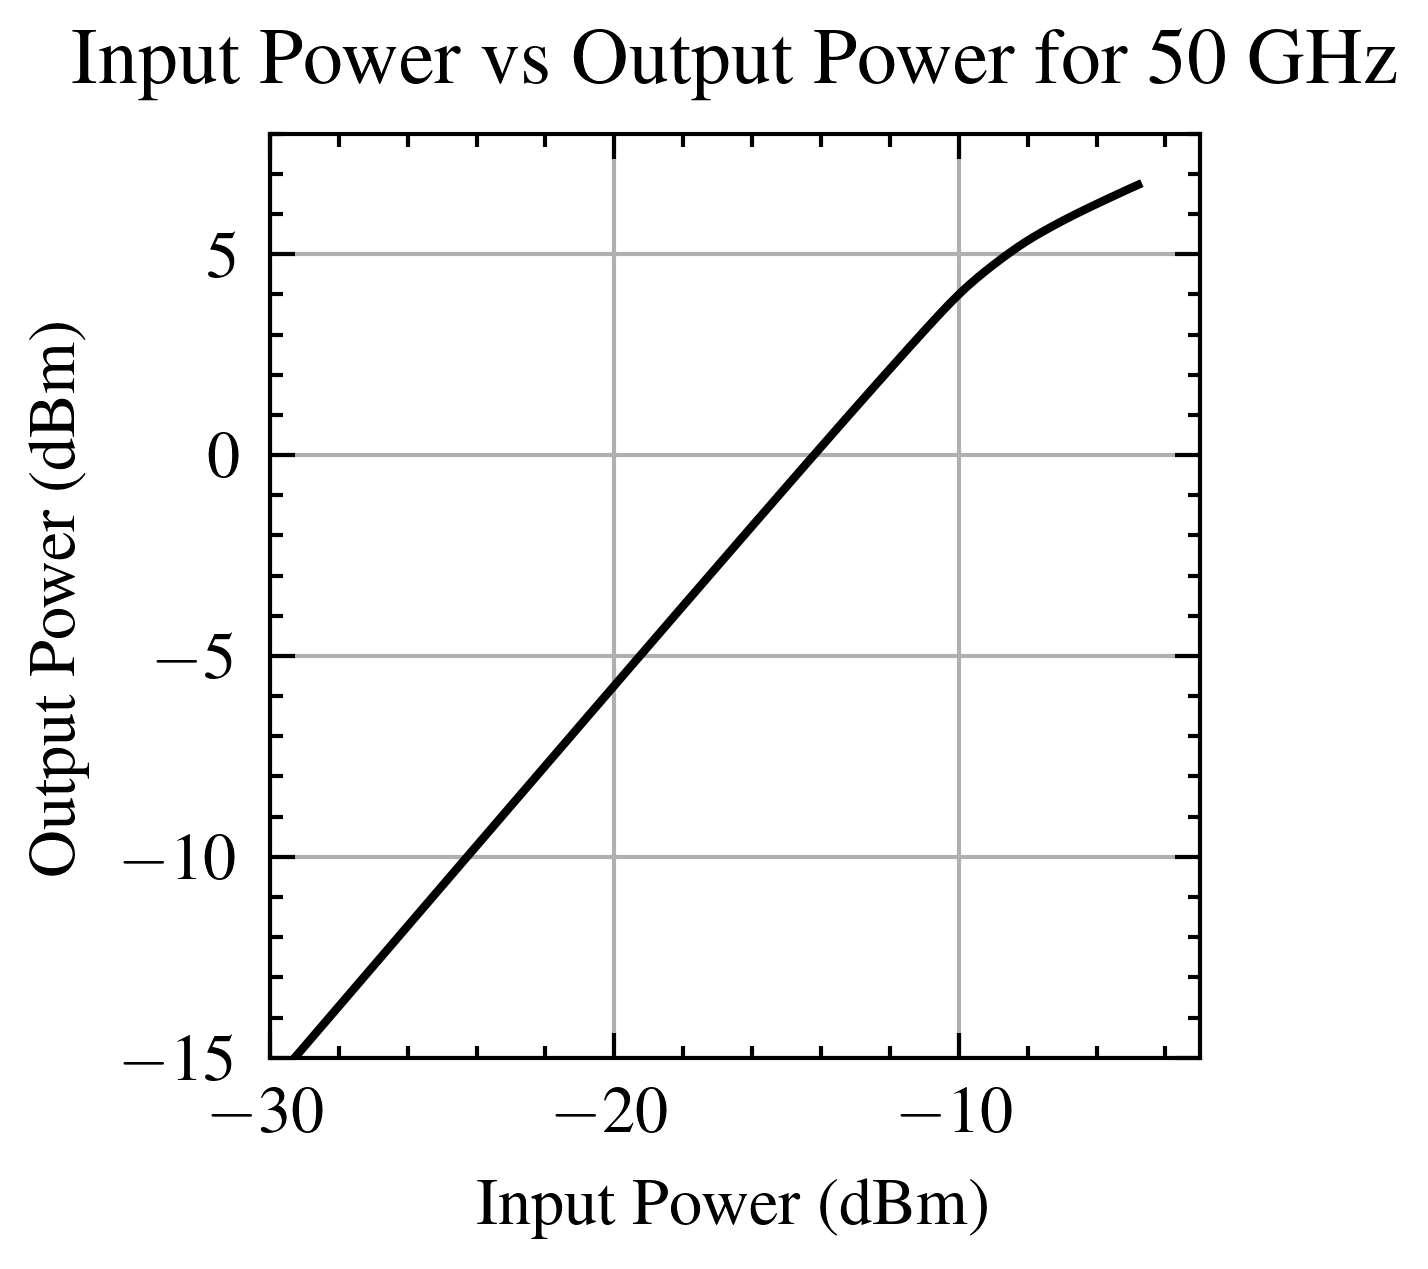

In [26]:
#plotting the Output power vs Input power for 50 GHz
plt.figure(figsize=(2, 2))
plt.plot(df_50_ghz['Pindbm'].values, df_50_ghz['Poutdbm'].values)
plt.xlabel('Input Power (dBm)')
plt.ylabel('Output Power (dBm)')
plt.title('Input Power vs Output Power for 50 GHz')
plt.xlim(-30, -3)
plt.ylim(-15, 8)
plt.grid()
plot_path = os.path.join(output_dir, 'output power vs input.png')
plt.savefig(plot_path, dpi=300)
plt.show()


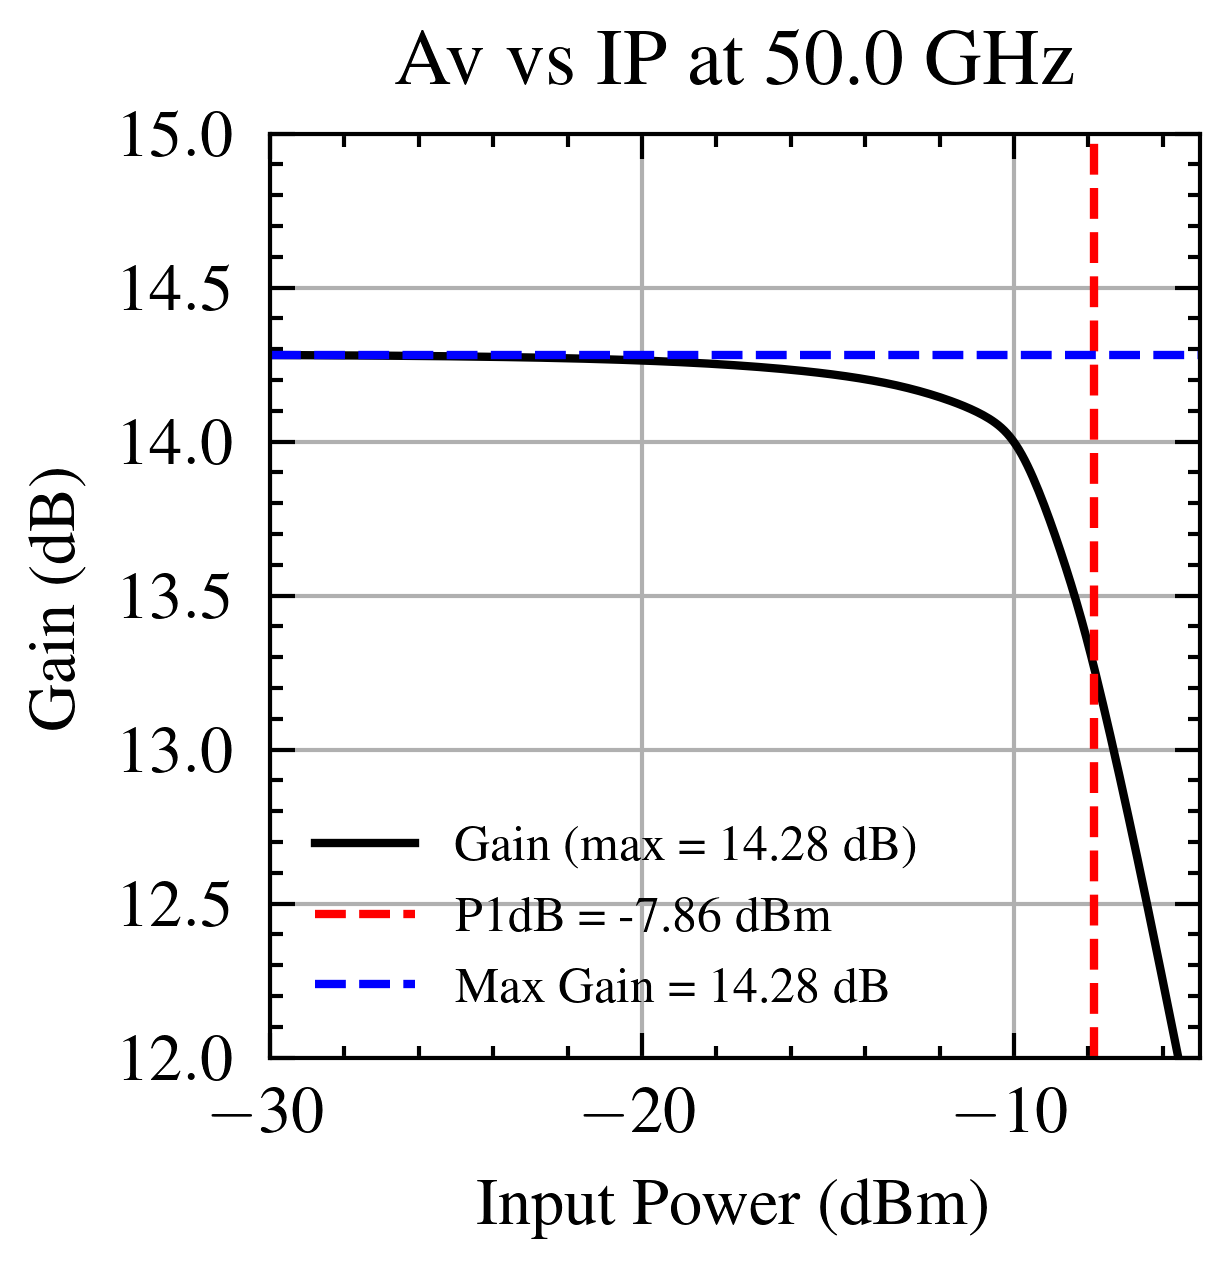

In [27]:
# Ensure the index is reset to default integer-based index
df_50_ghz = df_50_ghz.reset_index(drop=True)

# Continue with the existing calculation
Gain_db = df_50_ghz['Poutdbm'] - df_50_ghz['Pindbm']
max_gain = Gain_db.max()
max_gain_array = np.full(len(df_50_ghz['Pindbm']), max_gain)
max_gain_array_subtract = max_gain_array - Gain_db
max_gain_final = max_gain_array_subtract - 1
P1db_curve = abs(max_gain_final)
P1db_index = np.argmin(P1db_curve)

# Use the new reset index to access values
Po_p1db = np.array(P1db_curve)[P1db_index]
Pi_p1db = df_50_ghz['Pindbm'][P1db_index]

# Extract the maximum value for Gain_db
max_gain_db = Gain_db.max()

# Plot Gain vs. Input Power
plt.figure(figsize=(2, 2))
plt.plot(np.array(df_50_ghz['Pindbm']), np.array(Gain_db), label=f'Gain (max = {max_gain_db:.2f} dB)')
#plt.plot(df_50_ghz['Pindbm'], P1db_curve, label=f'P1dB (P1dB = {Pi_p1db:.2f} dBm)')
# Add a vertical line at the P1dB point
plt.axvline(x=Pi_p1db, color='red', linestyle='--', label=f'P1dB = {Pi_p1db:.2f} dBm')

# Add a horizontal line at the maximum Gain_db value
plt.axhline(y=max_gain_db, color='blue', linestyle='--', label=f'Max Gain = {max_gain_db:.2f} dB')

# Set labels and title
plt.xlabel("Input Power (dBm)")
plt.ylabel("Gain (dB)")
plt.title(f"Av vs IP at {50e9/1e9} GHz")

# Set x-axis limits
plt.xlim(-30, -5)
plt.ylim(12,15)

# Add grid, legend, and show the plot
plt.legend(fontsize=6)
plt.grid()
plot_path = os.path.join(output_dir, 'gain_vs_input_power.png')
plt.savefig(plot_path, dpi=300)
plt.show()